In [1]:
import requests
from bs4 import BeautifulSoup
import time
import re

In [2]:
def parse_object_page(url, object_n, object_list):
    """
    Fonction pour parser une page contenant des informations sur un type d'objet.
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Safari/537.3'}
    
    response = requests.get(url, headers=headers)

    if response.status_code == 200 :
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find('table', class_='ak-table ak-responsivetable')
        if table:
            for row in table.find_all("tr")[1:]:
                recipe = []
                caracteristics = []
                effects = []
                time.sleep(1)
                
                name_element = row.find("td").find("a")
                name = name_element.text.strip()
                href = name_element['href']

                if object_n in ["equipements", "armes", "consommables"] :

                    recipe_url = "https://www.dofus-touch.com" + href
                    recipe_response = requests.get(recipe_url, headers=headers)
                    recipe_soup = BeautifulSoup(recipe_response.text, "html.parser")
                    recipe_elements = recipe_soup.find_all(class_='ak-column ak-container col-xs-12 col-sm-6')

                    # Recipe elements
                    for element in recipe_elements:
                        span_elements = element.find_all('span', class_='ak-linker')
                        for span in span_elements:
                            text = span.text.strip()
                            if text != '':
                                recipe.append(text)
                    
                    # Properties elements
                    if object_n in ["equipements", "armes"] :
                        ak_contents  = recipe_soup.find_all("div", class_="col-sm-6")
                        for ak_content in ak_contents:
                            panel_titles = ak_content.find_all(class_="ak-panel-title")

                            if any("Caractéristiques" in panel_title.text for panel_title in panel_titles):
                                ak_titles = ak_content.find_all("div", class_="ak-title")
                                if ak_titles:
                                    for ak_title in ak_titles:
                                        text = ak_title.get_text(strip=True)
                                        caracteristics.append(text)
                            
                            if any("Effets" in panel_title.text for panel_title in panel_titles):
                                ak_titles = ak_content.find_all("div", class_="ak-title")
                                if ak_titles:
                                    for ak_title in ak_titles:
                                        text = ak_title.get_text(strip=True)
                                        effects.append(text)
                            
                            if any("Conditions" in panel_title.text for panel_title in panel_titles):
                                break

                name = row.find("td").find("img")['alt'].strip()
                type_ = row.find("td", class_="item-type").text.strip()
                level_str = row.find("td", class_="item-level").text.strip()
                level = int(re.search(r'\d+', level_str).group())

                object_info = {
                    "name": name,
                    "type": type_,
                    "level": level
                }

                if object_n in ["equipements", "armes", "consommables"] :
                    object_info["recipe"] = recipe
                    if object_n in ["equipements", "armes"] :
                        object_info["caracteristic"] = caracteristics
                        object_info["effect"] = effects

                object_list.append(object_info)
            return True  # Indique que la page a été analysée avec succès
    else:
        return False  # Indique qu'il y a eu une erreur lors de la requête

In [5]:
base_url = "https://www.dofus-touch.com/fr/mmorpg/encyclopedie"
objects = {
    "armes": [],
    "equipements": [],
    "consommables": [],
    "ressources": []
}

for object_name, object_list in objects.items():
    print(f"Object : {object_name}")
    url = f"{base_url}/{object_name}"
    while True :
        if parse_object_page(url, object_name, object_list) :
            break
        else :
            time.sleep(3)
    page = 2
    while True:
        page_url = f"{url}?page={page}"
        success = parse_object_page(page_url, object_name, object_list)
        if not success:
            break
        page += 1
    print(f"{len(object_list)} {object_name} find")

Object : armes
192 armes find
Object : equipements
240 equipements find
Object : consommables
192 consommables find
Object : ressources
1842 ressources find


In [6]:
print(objects["armes"][0])
print(objects["equipements"][0])
print(objects["consommables"][0])
print(objects["ressources"][0])

{'name': 'Hache Ériphe', 'type': 'Hache', 'level': 200, 'recipe': ['Galet acajou', 'Etoffe de Cuirassé', 'Bec de Strigide', 'Œil de verre', 'Essence de Glourséleste', "Graisse d'Archillusion", 'Écharpe de Hanshi', "Bracelet d'Ino-Naru"], 'caracteristic': ['PA :5 (1 utilisation par tour)', 'Portée :1', 'CC :15% (+8)', 'Force > 349 etAgilité de base > 349'], 'effect': ['15 à 19 (dommages Neutre)', '21 à 27 (dommages Air)', '8 à 11 (vol Terre)', '201 à 250 Vitalité', '41 à 60 Force', '41 à 60 Agilité', '4 à 5% Coups Critiques', '1 PO', '-301 à 400 Initiative', '11 à 15 Prospection', '14 à 18 Dommages Neutre', '14 à 18 Dommages Terre', '14 à 18 Dommages Air', '7 à 10 % Résistance Neutre', '7 à 10 % Résistance Air', '7 à 10 Fuite', '16 à 20 Dommages Poussée']}
{'name': 'Coiffe du Comte Harebourg', 'type': 'Chapeau', 'level': 200, 'recipe': ['Galet acajou', 'Oeil de Harrogant', 'Cuir de Cuirboule', "Sang d'Armutin", 'Plume de Sinistro', 'Aile de Sinistrofu', 'Œil de verre', 'Essence de Comte

In [5]:
import csv

def save_object_list_to_csv(object_list, filename):
    """
    Create and save the object_list to a CSV file.
    """
    # Define the fieldnames based on the keys in the dictionaries in object_list
    fieldnames = object_list[0].keys()

    # Write object_list to a CSV file
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for obj in object_list:
            writer.writerow(obj)

for object_name, object_list in objects.items():
    filename = f"{object_name}.csv"
    save_object_list_to_csv(object_list, filename)

In [21]:
import csv
import ast

def read_csv_file(filename):
    data = []  # List to store dictionaries for each row
    with open(filename, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)  # Using DictReader to directly read rows into dictionaries
        for row in reader:
            # Convert string into a list
            try :
                row['recipe'] = ast.literal_eval(row['recipe'])
                row['caracteristic'] = ast.literal_eval(row['caracteristic'])
                row['effect'] = ast.literal_eval(row['effect'])

            except :
                pass

            for key, value in row.items():
                if isinstance(value, str):  # Check if the value is a string
                    row[key] = value.replace("'", " ")
                elif isinstance(value, list):  # Check if the value is a list
                    row[key] = [element.replace("'", " ") for element in value]
                    
            data.append(row)
    return data

objects = {
    "armes": [],
    "equipements": [],
    "consommables": [],
    "ressources": []
}

for object_name, object_list in objects.items():
    object_list.extend(read_csv_file(f"{object_name}.csv"))

In [30]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_lvl(list_lvl) :
    # Calculer la fréquence de chaque nombre dans la liste
    compteur_nombres = Counter(list_lvl)

    # Extraire les nombres uniques et leurs fréquences
    nombres_uniques = list(compteur_nombres.keys())
    frequences = list(compteur_nombres.values())

    largeur_figure = 10  # Largeur en pouces
    hauteur_figure = 6   # Hauteur en pouces
    plt.figure(figsize=(largeur_figure, hauteur_figure))

    # Tracer le diagramme en barres
    plt.bar(nombres_uniques, frequences)
    plt.xlabel('Niveaux')
    plt.ylabel('Fréquence')
    plt.title(f"Fréquence des niveaux d'équipement")
    plt.show()

In [33]:
import re

def extract_lvl(str_item) :
    equipments = objects[str_item]
    niveaux_equipment = [equipement['level'] for equipement in equipments]    

    return niveaux_equipment

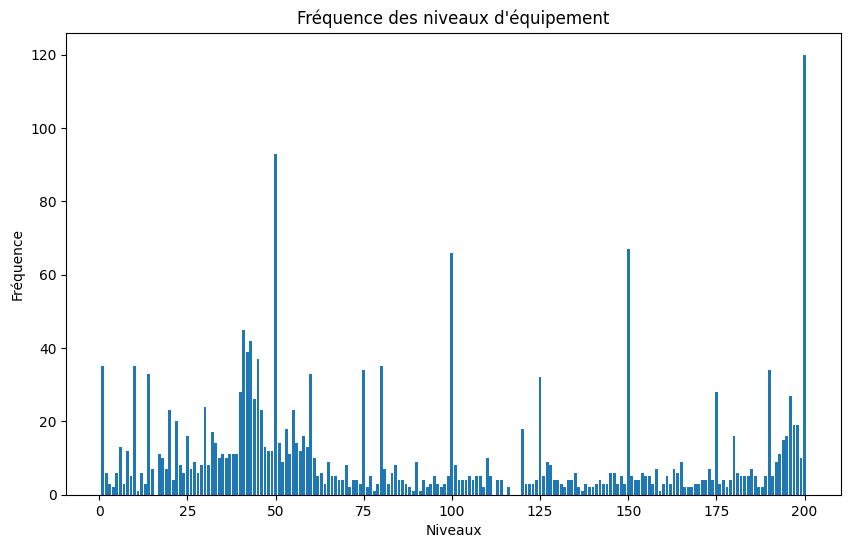

In [34]:
str_item = "equipements"
niveaux_equipment = extract_lvl(str_item)
plot_lvl(niveaux_equipment)

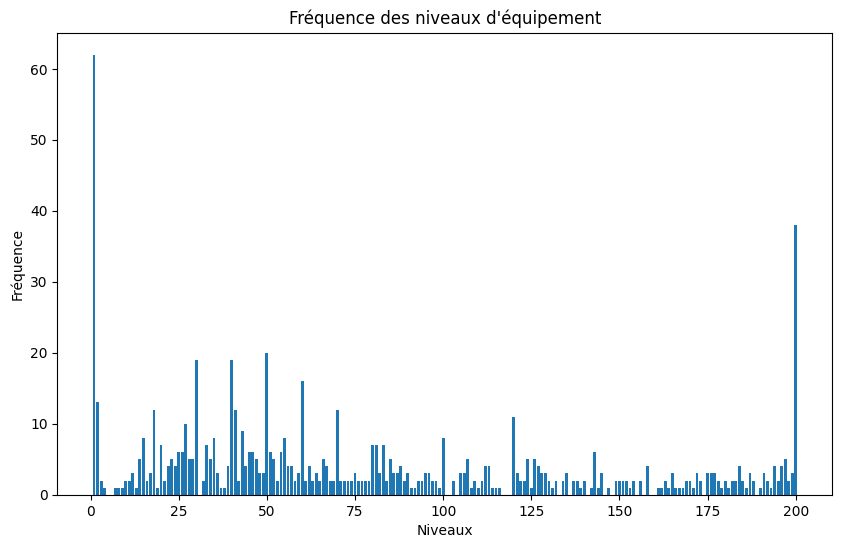

In [35]:
str_item = "armes"
niveaux_equipment = extract_lvl(str_item)
plot_lvl(niveaux_equipment)

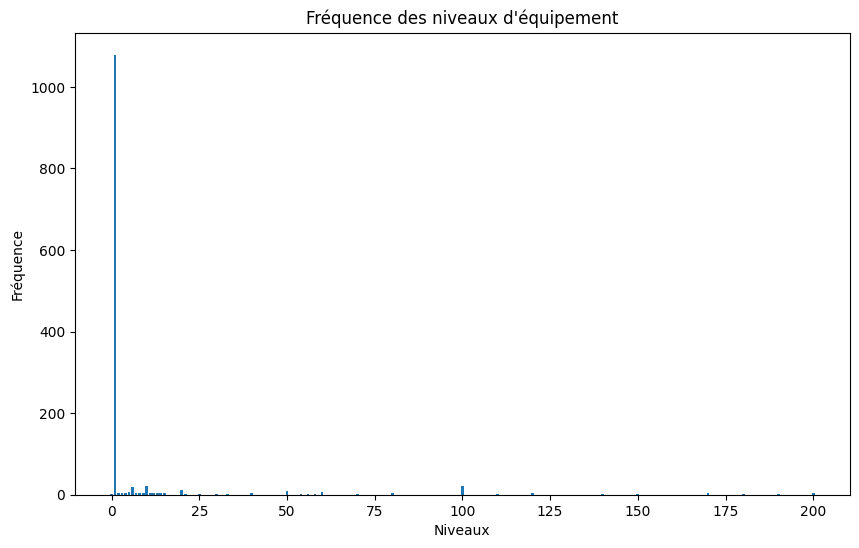

In [36]:
str_item = "consommables"
niveaux_equipment = extract_lvl(str_item)
plot_lvl(niveaux_equipment)

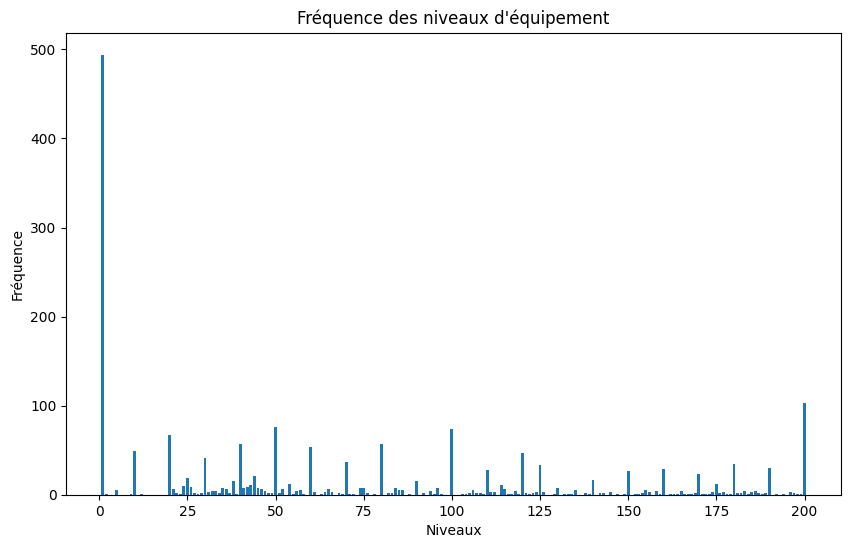

In [37]:
str_item = "ressources"
niveaux_equipment = extract_lvl(str_item)
plot_lvl(niveaux_equipment)

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "bolt://localhost:7687" 
AUTH = ("neo4j", "w0XLPdmPJ8Y_9HCTcfPrRPno3q_KQZdkh60dS0FsmCE")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    for object_name, object_list in objects.items():
        print(f"object_name : {object_name}")
        for obj in object_list:
            if object_name == "ressources":
                driver.execute_query(
                    f"CREATE (:{object_name} {{"
                    f"name: '{obj['name']}', "
                    f"type: '{obj['type']}', "
                    f"level: '{obj['level']}'"
                    f"}})"
                )
            else:
                driver.execute_query(
                    f"CREATE (:{object_name} {{"
                    f"name: '{obj['name']}', "
                    f"type: '{obj['type']}', "
                    f"level: '{obj['level']}', "
                    f"recipe: {obj.get('recipe', [])}"  # Use get method to handle missing 'recipe' key
                    f"}})"
                )

object_name : armes
object_name : equipements
object_name : consommables
object_name : ressources


In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    for object_name, object_list in objects.items():
        for obj in object_list:
            if obj.get('recipe'):
                for resource_name in obj['recipe']:
                    # Create a relationship between the object and the resource
                    print(f"{object_name}, {obj['name']}, {resource_name}")
                    driver.execute_query(
                        f"MATCH (o:{object_name} {{name: '{obj['name']}'}}), (r:resources {{name: '{resource_name}'}})"
                        f"CREATE (r)-[:CONTAINS]->(o)"
                    )

In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    for object_name, object_list in objects.items():
        for obj in object_list:
            if obj.get('recipe'):
                for resource_name in obj['recipe']:
                    # Create a relationship between the object and the resource
                    query = (
                        f"MATCH (o:{object_name} {{name: '{obj['name']}'}}), (r:ressources {{name: '{resource_name}'}}) "
                        "CREATE (o)-[:CONTAINS]->(r)"
                    )
                    print(query)
                    try:
                        with driver.session() as session:
                            session.run(query)
                    except Exception as e:
                        print(f"Error executing Cypher query: {query}")
                        print(f"Error message: {str(e)}")

MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Galet acajou'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Etoffe de Cuirassé'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Bec de Strigide'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Œil de verre'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Essence de Glourséleste'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Graisse d Archillusion'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Écharpe de Hanshi'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Hache Ériphe'}), (r:ressources {name: 'Bracelet d Ino-Naru'}) CREATE (o)-[:CONTAINS]->(r)
MATCH (o:armes {name: 'Sceptre du Shushuverain'}), (r:ressources {name: 'Etoffe de Kolosso'}) CREATE (o)-[:CON